# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## test dataset

In [15]:
notebook_login()

In [16]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [17]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [18]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [19]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [20]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [21]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [22]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

### Pretrain merge

In [23]:
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_five')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_three')

pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
pretrain_test_dataset=pretrain_test_dataset.rename_column("sequence", "text")
pretrain_test_dataset=pretrain_test_dataset.rename_column("labels_three_2p", "label")

pretrain_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 700
})

In [25]:
dataset_ccc = concatenate_datasets([dataset_cc,pretrain_test_dataset])
dataset_ccc

Dataset({
    features: ['text', 'label'],
    num_rows: 34748
})

## split 

In [26]:
ds = dataset_ccc.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 27798
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6950
    })
})

In [27]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27798
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6950
})


## label balance

<Axes: ylabel='count'>

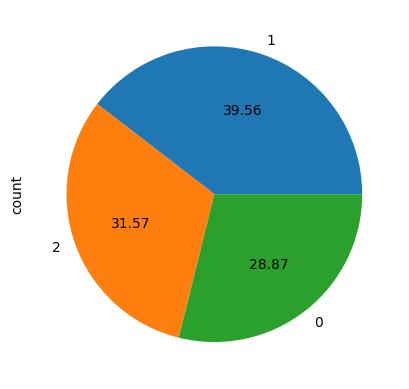

In [28]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

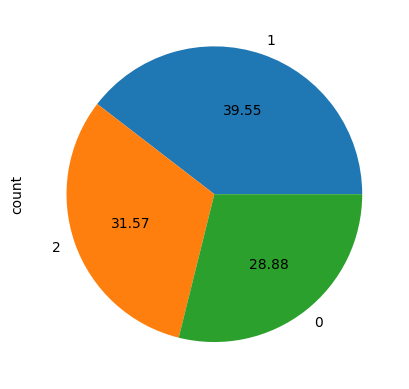

In [29]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

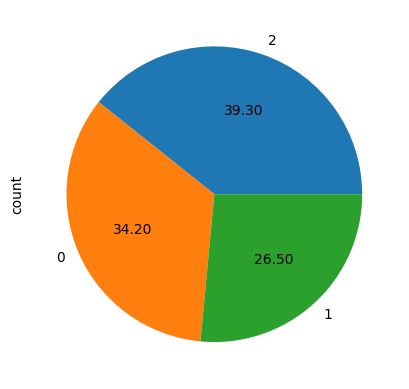

In [30]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

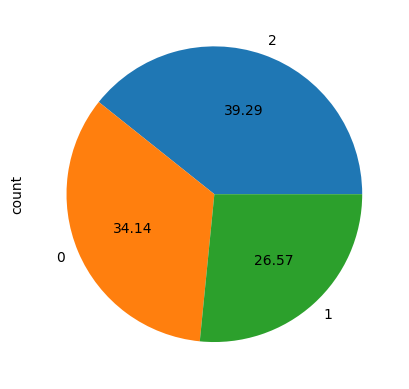

In [31]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.label.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [32]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 27798
})
Dataset({
    features: ['text', 'label'],
    num_rows: 6950
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 700
})


In [33]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/27798 [00:00<?, ? examples/s]

Map:   0%|          | 0/6950 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [34]:
model_id="lxyuan/distilbert-base-multilingual-cased-sentiments-student"



label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

DistilBertConfig {
  "_name_or_path": "lxyuan/distilbert-base-multilingual-cased-sentiments-student",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 2,
    "neutral": 1,
    "positive": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "vocab_size": 119547
}

In [35]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/27798 [00:00<?, ? examples/s]

Map:   0%|          | 0/6950 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [36]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [37]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [39]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [40]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

In [41]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [42]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-06 12:00:09,051] A new study created in memory with name: no-name-237bf878-ee2d-42f9-b3ac-87ac0f422128
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.0468, 'learning_rate': 1.358013731805802e-06, 'epoch': 1.15}
{'eval_loss': 0.8359916806221008, 'eval_accuracy': 0.640431654676259, 'eval_f1': 0.6408897466033693, 'eval_precision': 0.6493220461344641, 'eval_recall': 0.6360691406055028, 'eval_runtime': 22.9081, 'eval_samples_per_second': 303.386, 'eval_steps_per_second': 37.934, 'epoch': 1.15}
{'loss': 0.792, 'learning_rate': 9.526364984309358e-07, 'epoch': 2.3}
{'eval_loss': 0.7361564636230469, 'eval_accuracy': 0.6867625899280575, 'eval_f1': 0.6891978304061089, 'eval_precision': 0.6905435162499148, 'eval_recall': 0.6881189274447901, 'eval_runtime': 21.8281, 'eval_samples_per_second': 318.397, 'eval_steps_per_second': 39.811, 'epoch': 2.3}
{'loss': 0.7309, 'learning_rate': 5.472592650560695e-07, 'epoch': 3.45}
{'eval_loss': 0.7079921960830688, 'eval_accuracy': 0.6981294964028777, 'eval_f1': 0.7006584929279107, 'eval_precision': 0.7004978063816636, 'eval_recall': 0.7009023058759382, 'eval_runtime': 21.6966, 'eval_samples_per_se

[I 2023-12-06 12:28:18,336] Trial 0 finished with value: 2.8149886689437578 and parameters: {'learning_rate': 1.7633909651806684e-06, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 2.8149886689437578.


{'train_runtime': 1669.2393, 'train_samples_per_second': 83.265, 'train_steps_per_second': 1.303, 'train_loss': 0.8104965420426994, 'epoch': 5.0}


eval/accuracy,▁▆██
eval/f1,▁▆██
eval/loss,█▃▁▁
eval/precision,▁▆██
eval/recall,▁▆██
eval/runtime,█▂▁▂
eval/samples_per_second,▁▇█▇
eval/steps_per_second,▁▇█▇
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


{'loss': 0.8304, 'learning_rate': 0.0002212634377203919, 'epoch': 1.29}
{'eval_loss': 0.7517143487930298, 'eval_accuracy': 0.6923741007194245, 'eval_f1': 0.6939808354161029, 'eval_precision': 0.694376802582354, 'eval_recall': 0.6942801857990043, 'eval_runtime': 21.5225, 'eval_samples_per_second': 322.919, 'eval_steps_per_second': 40.376, 'epoch': 1.29}
{'loss': 0.6338, 'learning_rate': 5.389321251585944e-05, 'epoch': 2.58}
{'eval_loss': 0.7542621493339539, 'eval_accuracy': 0.7014388489208633, 'eval_f1': 0.7042304549920351, 'eval_precision': 0.7034787352498629, 'eval_recall': 0.7050597025723192, 'eval_runtime': 21.4995, 'eval_samples_per_second': 323.263, 'eval_steps_per_second': 40.42, 'epoch': 2.58}


[I 2023-12-06 12:50:47,145] Trial 1 finished with value: 2.8142077417350806 and parameters: {'learning_rate': 0.0003886336629249243, 'num_train_epochs': 3, 'per_device_train_batch_size': 72}. Best is trial 0 with value: 2.8149886689437578.


{'train_runtime': 1346.6572, 'train_samples_per_second': 61.927, 'train_steps_per_second': 0.862, 'train_loss': 0.7078184182021661, 'epoch': 3.0}


eval/accuracy,▁█
eval/f1,▁█
eval/loss,▁█
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▆▆█
train/global_step,▁▁▆▆█
train/learning_rate,█▁


{'loss': 1.1021, 'learning_rate': 0.00048295809791992756, 'epoch': 1.15}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0896153450012207, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.6372, 'eval_samples_per_second': 321.207, 'eval_steps_per_second': 40.162, 'epoch': 1.15}
{'loss': 1.0911, 'learning_rate': 0.0003387915015259194, 'epoch': 2.3}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0897563695907593, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.5453, 'eval_samples_per_second': 322.575, 'eval_steps_per_second': 40.334, 'epoch': 2.3}
{'loss': 1.0899, 'learning_rate': 0.00019462490513191114, 'epoch': 3.45}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0897728204727173, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 22.1615, 'eval_samples_per_second': 313.607, 'eval_steps_per_second': 39.212, 'epoch': 3.45}
{'loss': 1.0894, 'learning_rate': 5.045830873790288e-05, 'epoch': 4.6}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.0898739099502563, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 22.2884, 'eval_samples_per_second': 311.822, 'eval_steps_per_second': 38.989, 'epoch': 4.6}


[I 2023-12-06 13:14:16,764] Trial 2 finished with value: 1.0496736121773784 and parameters: {'learning_rate': 0.0006271246943139358, 'num_train_epochs': 5, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 2.8149886689437578.


{'train_runtime': 1407.5941, 'train_samples_per_second': 98.743, 'train_steps_per_second': 1.545, 'train_loss': 1.0929673047997486, 'epoch': 5.0}


eval/accuracy,▁▁▁▁
eval/f1,▁▁▁▁
eval/loss,▁▅▅█
eval/precision,▁▁▁▁
eval/recall,▁▁▁▁
eval/runtime,▂▁▇█
eval/samples_per_second,▇█▂▁
eval/steps_per_second,▇█▂▁
train/epoch,▁▁▃▃▅▅▇▇█
train/global_step,▁▁▃▃▅▅▇▇█
train/learning_rate,█▆▃▁


{'loss': 0.7741, 'learning_rate': 0.0001202197361793932, 'epoch': 0.72}
{'eval_loss': 0.6746583580970764, 'eval_accuracy': 0.7194244604316546, 'eval_f1': 0.7219625635070502, 'eval_precision': 0.7196220280300812, 'eval_recall': 0.7283780374329046, 'eval_runtime': 22.7678, 'eval_samples_per_second': 305.256, 'eval_steps_per_second': 38.168, 'epoch': 0.72}
{'loss': 0.589, 'learning_rate': 8.229552918273918e-05, 'epoch': 1.44}
{'eval_loss': 0.6409605145454407, 'eval_accuracy': 0.7420143884892086, 'eval_f1': 0.7456232149994663, 'eval_precision': 0.7482524154480555, 'eval_recall': 0.7449873500267618, 'eval_runtime': 22.6933, 'eval_samples_per_second': 306.258, 'eval_steps_per_second': 38.293, 'epoch': 1.44}
{'loss': 0.4747, 'learning_rate': 4.4371322186085176e-05, 'epoch': 2.16}
{'eval_loss': 0.7287597060203552, 'eval_accuracy': 0.739568345323741, 'eval_f1': 0.7422314556350483, 'eval_precision': 0.7478774699460233, 'eval_recall': 0.7384077366972548, 'eval_runtime': 22.6365, 'eval_samples_per

[I 2023-12-06 13:29:49,911] Trial 3 finished with value: 2.9936470155228627 and parameters: {'learning_rate': 0.00015814394317604719, 'num_train_epochs': 3, 'per_device_train_batch_size': 40}. Best is trial 3 with value: 2.9936470155228627.


{'train_runtime': 931.0186, 'train_samples_per_second': 89.573, 'train_steps_per_second': 2.239, 'train_loss': 0.5337298294908994, 'epoch': 3.0}


eval/accuracy,▁▇▆█
eval/f1,▁▇▆█
eval/loss,▄▁█▇
eval/precision,▁▇▇█
eval/recall,▁▇▅█
eval/runtime,█▇▆▁
eval/samples_per_second,▁▂▃█
eval/steps_per_second,▁▂▃█
train/epoch,▁▁▃▃▅▅███
train/global_step,▁▁▃▃▅▅███
train/learning_rate,█▆▃▁


{'loss': 1.1502, 'learning_rate': 6.711176521468669e-07, 'epoch': 0.86}
{'eval_loss': 0.9758309721946716, 'eval_accuracy': 0.5646043165467626, 'eval_f1': 0.5546757330561926, 'eval_precision': 0.5903500888259771, 'eval_recall': 0.5493770772447619, 'eval_runtime': 22.2083, 'eval_samples_per_second': 312.947, 'eval_steps_per_second': 39.13, 'epoch': 0.86}
{'loss': 0.9368, 'learning_rate': 1.6269518839924047e-07, 'epoch': 1.72}
{'eval_loss': 0.8946164846420288, 'eval_accuracy': 0.6110791366906475, 'eval_f1': 0.6109824048442932, 'eval_precision': 0.618832813947013, 'eval_recall': 0.6067036081584359, 'eval_runtime': 21.8117, 'eval_samples_per_second': 318.637, 'eval_steps_per_second': 39.841, 'epoch': 1.72}


[I 2023-12-06 13:39:15,720] Trial 4 finished with value: 2.4475979636403897 and parameters: {'learning_rate': 1.1795401158944933e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 48}. Best is trial 3 with value: 2.9936470155228627.


{'train_runtime': 563.6302, 'train_samples_per_second': 98.639, 'train_steps_per_second': 2.058, 'train_loss': 1.0245977467504042, 'epoch': 2.0}


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▆▆█
train/global_step,▁▁▆▆█
train/learning_rate,█▁


{'loss': 0.8027, 'learning_rate': 2.4459760468840254e-05, 'epoch': 0.29}
{'eval_loss': 0.6635556817054749, 'eval_accuracy': 0.7070503597122302, 'eval_f1': 0.7102087412010064, 'eval_precision': 0.709478858764804, 'eval_recall': 0.7179499624338227, 'eval_runtime': 21.7029, 'eval_samples_per_second': 320.233, 'eval_steps_per_second': 40.041, 'epoch': 0.29}
{'loss': 0.6677, 'learning_rate': 2.0350257701898005e-05, 'epoch': 0.58}
{'eval_loss': 0.622546374797821, 'eval_accuracy': 0.7358273381294964, 'eval_f1': 0.7378863553204487, 'eval_precision': 0.7471672121058205, 'eval_recall': 0.7332424998646875, 'eval_runtime': 21.6511, 'eval_samples_per_second': 321.0, 'eval_steps_per_second': 40.137, 'epoch': 0.58}
{'loss': 0.6333, 'learning_rate': 1.624075493495576e-05, 'epoch': 0.86}
{'eval_loss': 0.6305841207504272, 'eval_accuracy': 0.7420143884892086, 'eval_f1': 0.7454855015207206, 'eval_precision': 0.7463020830474267, 'eval_recall': 0.7453625277234509, 'eval_runtime': 21.6508, 'eval_samples_per_

[I 2023-12-06 13:53:16,690] Trial 5 finished with value: 3.0043631961514823 and parameters: {'learning_rate': 2.85692632357825e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 3.0043631961514823.


{'train_runtime': 838.7809, 'train_samples_per_second': 66.282, 'train_steps_per_second': 4.144, 'train_loss': 0.5926444621025762, 'epoch': 2.0}


eval/accuracy,▁▆▇▇▇█
eval/f1,▁▆▇▇▇█
eval/loss,█▁▂▃▅▁
eval/precision,▁▆▆▆█▇
eval/recall,▁▄▇▇▆█
eval/runtime,█▄▄▃▁▄
eval/samples_per_second,▁▅▅▆█▅
eval/steps_per_second,▁▅▅▆█▅
train/epoch,▁▁▂▂▃▃▅▅▆▆▇▇█
train/global_step,▁▁▂▂▃▃▅▅▆▆▇▇█
train/learning_rate,█▇▅▄▂▁


{'loss': 1.0862, 'learning_rate': 0.0001778119363923757, 'epoch': 0.58}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-06 13:56:06,996] Trial 6 pruned. 


{'eval_loss': 1.080824851989746, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.6932, 'eval_samples_per_second': 320.376, 'eval_steps_per_second': 40.059, 'epoch': 0.58}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.0048, 'learning_rate': 0.00018690378163909474, 'epoch': 1.01}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-06 14:00:31,615] Trial 7 pruned. 


{'eval_loss': 0.9599189162254333, 'eval_accuracy': 0.5267625899280576, 'eval_f1': 0.41058236323580505, 'eval_precision': 0.42932364002573803, 'eval_recall': 0.4768927879522831, 'eval_runtime': 22.7292, 'eval_samples_per_second': 305.773, 'eval_steps_per_second': 38.233, 'epoch': 1.01}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.1092, 'learning_rate': 2.3595916118697088e-07, 'epoch': 0.86}


[I 2023-12-06 14:04:25,520] Trial 8 pruned. 


{'eval_loss': 0.9708230495452881, 'eval_accuracy': 0.5686330935251799, 'eval_f1': 0.5621428407414285, 'eval_precision': 0.5901170804993484, 'eval_recall': 0.5565780467291049, 'eval_runtime': 21.828, 'eval_samples_per_second': 318.398, 'eval_steps_per_second': 39.811, 'epoch': 0.86}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 1.0941, 'learning_rate': 0.0002691061315529558, 'epoch': 0.58}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-06 14:07:14,574] Trial 9 pruned. 


{'eval_loss': 1.089245080947876, 'eval_accuracy': 0.3955395683453237, 'eval_f1': 0.18895418771694675, 'eval_precision': 0.13184652278177458, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.7075, 'eval_samples_per_second': 320.166, 'eval_steps_per_second': 40.032, 'epoch': 0.58}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.8216, 'learning_rate': 1.4140184259191494e-05, 'epoch': 0.29}
{'eval_loss': 0.6667323708534241, 'eval_accuracy': 0.7070503597122302, 'eval_f1': 0.7106820542339499, 'eval_precision': 0.7110076854474614, 'eval_recall': 0.7151068197307476, 'eval_runtime': 21.7443, 'eval_samples_per_second': 319.623, 'eval_steps_per_second': 39.964, 'epoch': 0.29}
{'loss': 0.6721, 'learning_rate': 8.429285931569729e-06, 'epoch': 0.58}
{'eval_loss': 0.6362132430076599, 'eval_accuracy': 0.7335251798561151, 'eval_f1': 0.7345036827015393, 'eval_precision': 0.7485642871724977, 'eval_recall': 0.7285182697897289, 'eval_runtime': 21.6511, 'eval_samples_per_second': 321.0, 'eval_steps_per_second': 40.137, 'epoch': 0.58}
{'loss': 0.6395, 'learning_rate': 2.718387603947961e-06, 'epoch': 0.86}
{'eval_loss': 0.6145224571228027, 'eval_accuracy': 0.7410071942446043, 'eval_f1': 0.7439406433292896, 'eval_precision': 0.7494041135594851, 'eval_recall': 0.7400379035649446, 'eval_runtime': 21.6361, 'eval_samples_per

[I 2023-12-06 14:14:12,360] Trial 10 finished with value: 2.9743898546983236 and parameters: {'learning_rate': 1.9851082586813263e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 16}. Best is trial 5 with value: 3.0043631961514823.


{'train_runtime': 416.0839, 'train_samples_per_second': 66.809, 'train_steps_per_second': 4.177, 'train_loss': 0.7002706582581901, 'epoch': 1.0}


eval/accuracy,▁▆█
eval/f1,▁▆█
eval/loss,█▄▁
eval/precision,▁██
eval/recall,▁▅█
eval/runtime,█▂▁
eval/samples_per_second,▁▇█
eval/steps_per_second,▁▇█
train/epoch,▁▁▄▄▇▇█
train/global_step,▁▁▄▄▇▇█
train/learning_rate,█▅▁


{'loss': 0.728, 'learning_rate': 5.1615086094030566e-05, 'epoch': 0.72}
{'eval_loss': 0.642192006111145, 'eval_accuracy': 0.7293525179856115, 'eval_f1': 0.7317381151300676, 'eval_precision': 0.728818763262912, 'eval_recall': 0.7389673354712653, 'eval_runtime': 21.8313, 'eval_samples_per_second': 318.351, 'eval_steps_per_second': 39.805, 'epoch': 0.72}
{'loss': 0.5567, 'learning_rate': 4.0295988266392284e-05, 'epoch': 1.44}
{'eval_loss': 0.6137428283691406, 'eval_accuracy': 0.7496402877697842, 'eval_f1': 0.7532720693609548, 'eval_precision': 0.7529678417903808, 'eval_recall': 0.754150923399418, 'eval_runtime': 21.7758, 'eval_samples_per_second': 319.162, 'eval_steps_per_second': 39.907, 'epoch': 1.44}
{'loss': 0.4511, 'learning_rate': 2.8976890438754003e-05, 'epoch': 2.16}
{'eval_loss': 0.713091254234314, 'eval_accuracy': 0.7497841726618705, 'eval_f1': 0.7524939354533181, 'eval_precision': 0.7526315259962547, 'eval_recall': 0.7534346491643665, 'eval_runtime': 21.8012, 'eval_samples_per_

[I 2023-12-06 14:33:47,278] Trial 11 finished with value: 3.029077467070818 and parameters: {'learning_rate': 6.293418392166885e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 40}. Best is trial 11 with value: 3.029077467070818.


{'train_runtime': 1172.923, 'train_samples_per_second': 94.799, 'train_steps_per_second': 2.37, 'train_loss': 0.4301474852527646, 'epoch': 4.0}


eval/accuracy,▁▇▇██
eval/f1,▁▇▇▇█
eval/loss,▂▁▄▄█
eval/precision,▁▇▇▇█
eval/recall,▁▇▆▇█
eval/runtime,█▁▄▅▁
eval/samples_per_second,▁█▅▄█
eval/steps_per_second,▁█▅▄█
train/epoch,▁▁▃▃▄▄▆▆▇▇█
train/global_step,▁▁▃▃▄▄▆▆▇▇█
train/learning_rate,█▆▄▃▁


{'loss': 0.7991, 'learning_rate': 3.44827420157287e-05, 'epoch': 0.29}
{'eval_loss': 0.6702519655227661, 'eval_accuracy': 0.7040287769784173, 'eval_f1': 0.7073527288973208, 'eval_precision': 0.70724137359925, 'eval_recall': 0.7147004578182492, 'eval_runtime': 22.5284, 'eval_samples_per_second': 308.5, 'eval_steps_per_second': 38.574, 'epoch': 0.29}
{'loss': 0.6726, 'learning_rate': 3.181048984463999e-05, 'epoch': 0.58}
{'eval_loss': 0.6261724233627319, 'eval_accuracy': 0.73568345323741, 'eval_f1': 0.7375054580894638, 'eval_precision': 0.7460533668694618, 'eval_recall': 0.7329065306180048, 'eval_runtime': 23.0223, 'eval_samples_per_second': 301.882, 'eval_steps_per_second': 37.746, 'epoch': 0.58}
{'loss': 0.6379, 'learning_rate': 2.9138237673551282e-05, 'epoch': 0.86}
{'eval_loss': 0.6366569995880127, 'eval_accuracy': 0.7423021582733813, 'eval_f1': 0.7454649213351551, 'eval_precision': 0.7489431001354729, 'eval_recall': 0.7428350653705192, 'eval_runtime': 23.0078, 'eval_samples_per_seco

[I 2023-12-06 14:44:19,990] Trial 12 pruned. 


{'eval_loss': 0.6597767472267151, 'eval_accuracy': 0.7453237410071942, 'eval_f1': 0.746812173627123, 'eval_precision': 0.7661350530683037, 'eval_recall': 0.7381970005344168, 'eval_runtime': 22.7392, 'eval_samples_per_second': 305.64, 'eval_steps_per_second': 38.216, 'epoch': 1.44}


eval/accuracy,▁▆▇██
eval/f1,▁▆███
eval/loss,█▁▃▆▆
eval/precision,▁▆▆▆█
eval/recall,▁▅▇█▆
eval/runtime,▁██▃▄
eval/samples_per_second,█▁▁▆▅
eval/steps_per_second,█▁▁▆▅
train/epoch,▁▁▃▃▄▄▆▆██
train/global_step,▁▁▃▃▅▅▆▆██
train/learning_rate,█▆▅▃▁


{'loss': 0.7305, 'learning_rate': 4.232102599702001e-05, 'epoch': 0.72}
{'eval_loss': 0.63150954246521, 'eval_accuracy': 0.7372661870503597, 'eval_f1': 0.7402459810173502, 'eval_precision': 0.737680892408579, 'eval_recall': 0.7444283881609888, 'eval_runtime': 23.0184, 'eval_samples_per_second': 301.932, 'eval_steps_per_second': 37.752, 'epoch': 0.72}
{'loss': 0.5607, 'learning_rate': 3.3040099243287554e-05, 'epoch': 1.44}
{'eval_loss': 0.5982124209403992, 'eval_accuracy': 0.7512230215827338, 'eval_f1': 0.7546814955498529, 'eval_precision': 0.755991210812128, 'eval_recall': 0.7535193436956633, 'eval_runtime': 22.9108, 'eval_samples_per_second': 303.35, 'eval_steps_per_second': 37.93, 'epoch': 1.44}
{'loss': 0.4626, 'learning_rate': 2.3759172489555094e-05, 'epoch': 2.16}
{'eval_loss': 0.7152206301689148, 'eval_accuracy': 0.7470503597122302, 'eval_f1': 0.7496264696019961, 'eval_precision': 0.7520825477020286, 'eval_recall': 0.7488468423059423, 'eval_runtime': 22.7407, 'eval_samples_per_se

[I 2023-12-06 15:04:58,497] Trial 13 finished with value: 2.9999550205504764 and parameters: {'learning_rate': 5.160195275075247e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 40}. Best is trial 11 with value: 3.029077467070818.


{'train_runtime': 1236.4362, 'train_samples_per_second': 89.929, 'train_steps_per_second': 2.248, 'train_loss': 0.44650184027582623, 'epoch': 4.0}


eval/accuracy,▁█▆█▆
eval/f1,▁█▅█▆
eval/loss,▂▁▅▄█
eval/precision,▁█▇▇▆
eval/recall,▁▆▄█▅
eval/runtime,▆▄▁█▅
eval/samples_per_second,▃▅█▁▄
eval/steps_per_second,▃▅█▁▄
train/epoch,▁▁▃▃▄▄▆▆▇▇█
train/global_step,▁▁▃▃▄▄▆▆▇▇█
train/learning_rate,█▆▄▃▁


{'loss': 0.8128, 'learning_rate': 1.0915342402848392e-05, 'epoch': 0.43}
{'eval_loss': 0.6722811460494995, 'eval_accuracy': 0.7084892086330935, 'eval_f1': 0.7105969117369354, 'eval_precision': 0.7076960886167013, 'eval_recall': 0.7181621949413669, 'eval_runtime': 23.2154, 'eval_samples_per_second': 299.371, 'eval_steps_per_second': 37.432, 'epoch': 0.43}
{'loss': 0.6655, 'learning_rate': 7.913323040128813e-06, 'epoch': 0.86}


[I 2023-12-06 15:10:05,343] Trial 14 pruned. 


{'eval_loss': 0.6338003873825073, 'eval_accuracy': 0.7335251798561151, 'eval_f1': 0.73659662972345, 'eval_precision': 0.738958020977004, 'eval_recall': 0.7346409577862744, 'eval_runtime': 23.1306, 'eval_samples_per_second': 300.468, 'eval_steps_per_second': 37.569, 'epoch': 0.86}


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,▁█
eval/recall,▁█
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁██
train/global_step,▁▁██
train/learning_rate,█▁


{'loss': 0.7358, 'learning_rate': 5.892324394718955e-05, 'epoch': 0.65}
{'eval_loss': 0.6286357641220093, 'eval_accuracy': 0.7375539568345324, 'eval_f1': 0.7412647835797018, 'eval_precision': 0.7526491353186073, 'eval_recall': 0.7349570084568802, 'eval_runtime': 22.7051, 'eval_samples_per_second': 306.099, 'eval_steps_per_second': 38.273, 'epoch': 0.65}
{'loss': 0.5721, 'learning_rate': 4.755687744503107e-05, 'epoch': 1.29}
{'eval_loss': 0.6297969818115234, 'eval_accuracy': 0.745179856115108, 'eval_f1': 0.7482587750765832, 'eval_precision': 0.7471060965809659, 'eval_recall': 0.7497313512710874, 'eval_runtime': 21.8466, 'eval_samples_per_second': 318.128, 'eval_steps_per_second': 39.777, 'epoch': 1.29}
{'loss': 0.4899, 'learning_rate': 3.61905109428726e-05, 'epoch': 1.94}
{'eval_loss': 0.6110407710075378, 'eval_accuracy': 0.7581294964028777, 'eval_f1': 0.7614539159985666, 'eval_precision': 0.7626659467164535, 'eval_recall': 0.7607340553516, 'eval_runtime': 22.1787, 'eval_samples_per_sec

[I 2023-12-06 15:31:08,275] Trial 15 finished with value: 3.0183660625027287 and parameters: {'learning_rate': 7.028961044934803e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 36}. Best is trial 11 with value: 3.029077467070818.


{'train_runtime': 1260.8235, 'train_samples_per_second': 88.19, 'train_steps_per_second': 2.452, 'train_loss': 0.4213516240286488, 'epoch': 4.0}


eval/accuracy,▁▄█▆▄▆
eval/f1,▁▃█▆▄▆
eval/loss,▁▁▁▅▇█
eval/precision,▃▁█▇▄▅
eval/recall,▁▅█▆▄▆
eval/runtime,█▂▄▂▁▂
eval/samples_per_second,▁▇▅▇█▇
eval/steps_per_second,▁▇▅▇█▇
train/epoch,▁▁▂▂▄▄▅▅▆▆███
train/global_step,▁▁▂▂▄▄▅▅▆▆███
train/learning_rate,█▇▅▄▂▁


{'loss': 0.7443, 'learning_rate': 7.807674548950631e-05, 'epoch': 0.65}
{'eval_loss': 0.6363972425460815, 'eval_accuracy': 0.7359712230215827, 'eval_f1': 0.7387536784900502, 'eval_precision': 0.7527087537160497, 'eval_recall': 0.7311788407322061, 'eval_runtime': 21.7937, 'eval_samples_per_second': 318.9, 'eval_steps_per_second': 39.874, 'epoch': 0.65}
{'loss': 0.5824, 'learning_rate': 6.301564489353674e-05, 'epoch': 1.29}
{'eval_loss': 0.6322556734085083, 'eval_accuracy': 0.7494964028776978, 'eval_f1': 0.752931435895874, 'eval_precision': 0.7606462710909047, 'eval_recall': 0.7480295912251727, 'eval_runtime': 21.791, 'eval_samples_per_second': 318.938, 'eval_steps_per_second': 39.879, 'epoch': 1.29}
{'loss': 0.4979, 'learning_rate': 4.795454429756715e-05, 'epoch': 1.94}
{'eval_loss': 0.6317777633666992, 'eval_accuracy': 0.7440287769784173, 'eval_f1': 0.7475471091995743, 'eval_precision': 0.7454528244954058, 'eval_recall': 0.7517884434387704, 'eval_runtime': 21.7906, 'eval_samples_per_se

[I 2023-12-06 15:51:02,767] Trial 16 pruned. 


{'eval_loss': 0.9627853631973267, 'eval_accuracy': 0.7397122302158273, 'eval_f1': 0.7432055541986063, 'eval_precision': 0.7463629108655905, 'eval_recall': 0.7406642613316129, 'eval_runtime': 21.8032, 'eval_samples_per_second': 318.761, 'eval_steps_per_second': 39.857, 'epoch': 3.88}


eval/accuracy,▁█▅█▄▃
eval/f1,▁█▅█▄▃
eval/loss,▁▁▁▃▇█
eval/precision,▄█▁▆▂▁
eval/recall,▁▇██▅▄
eval/runtime,▆▅▅▄▁█
eval/samples_per_second,▃▄▄▅█▁
eval/steps_per_second,▃▄▄▅█▁
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
train/learning_rate,█▇▅▄▂▁


{'loss': 1.105, 'learning_rate': 0.000780083776896659, 'epoch': 0.65}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-06 15:54:06,971] Trial 17 pruned. 


{'eval_loss': 1.095459222793579, 'eval_accuracy': 0.3156834532374101, 'eval_f1': 0.1599591717701954, 'eval_precision': 0.10522781774580336, 'eval_recall': 0.3333333333333333, 'eval_runtime': 21.8591, 'eval_samples_per_second': 317.946, 'eval_steps_per_second': 39.755, 'epoch': 0.65}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/learning_rate,▁


{'loss': 0.7421, 'learning_rate': 7.482190781893321e-05, 'epoch': 0.65}
{'eval_loss': 0.6364092826843262, 'eval_accuracy': 0.736546762589928, 'eval_f1': 0.740257456737471, 'eval_precision': 0.7497075315210915, 'eval_recall': 0.7349316571463387, 'eval_runtime': 22.7932, 'eval_samples_per_second': 304.916, 'eval_steps_per_second': 38.125, 'epoch': 0.65}
{'loss': 0.5817, 'learning_rate': 6.370423949516899e-05, 'epoch': 1.29}
{'eval_loss': 0.6351467370986938, 'eval_accuracy': 0.74431654676259, 'eval_f1': 0.7472552521903898, 'eval_precision': 0.7474122119738539, 'eval_recall': 0.7471091952387021, 'eval_runtime': 21.784, 'eval_samples_per_second': 319.042, 'eval_steps_per_second': 39.892, 'epoch': 1.29}
{'loss': 0.504, 'learning_rate': 5.258657117140477e-05, 'epoch': 1.94}
{'eval_loss': 0.6226815581321716, 'eval_accuracy': 0.7471942446043165, 'eval_f1': 0.7504003188767102, 'eval_precision': 0.7485470503521675, 'eval_recall': 0.7559826329380779, 'eval_runtime': 21.7937, 'eval_samples_per_seco

[I 2023-12-06 16:14:05,847] Trial 18 pruned. 


{'eval_loss': 0.8847213387489319, 'eval_accuracy': 0.7437410071942446, 'eval_f1': 0.7459370432204969, 'eval_precision': 0.7556832583144057, 'eval_recall': 0.7402112128254145, 'eval_runtime': 21.8416, 'eval_samples_per_second': 318.2, 'eval_steps_per_second': 39.786, 'epoch': 3.88}


eval/accuracy,▁▆▇█▇▅
eval/f1,▁▅▇█▇▅
eval/loss,▁▁▁▃█▇
eval/precision,▃▁▂█▆█
eval/recall,▁▅█▅▅▃
eval/runtime,█▁▁▇▆▁
eval/samples_per_second,▁██▂▃█
eval/steps_per_second,▁██▂▃█
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
train/learning_rate,█▇▅▄▂▁


{'loss': 0.8014, 'learning_rate': 9.496112175299287e-06, 'epoch': 0.72}
{'eval_loss': 0.6535943150520325, 'eval_accuracy': 0.7218705035971223, 'eval_f1': 0.725291298058206, 'eval_precision': 0.7252469903238206, 'eval_recall': 0.726515614041599, 'eval_runtime': 22.0282, 'eval_samples_per_second': 315.505, 'eval_steps_per_second': 39.449, 'epoch': 0.72}
{'loss': 0.6248, 'learning_rate': 7.4136314351020745e-06, 'epoch': 1.44}
{'eval_loss': 0.6254054307937622, 'eval_accuracy': 0.7369784172661871, 'eval_f1': 0.7401148562719323, 'eval_precision': 0.7418936564393902, 'eval_recall': 0.7385703966834677, 'eval_runtime': 23.1615, 'eval_samples_per_second': 300.066, 'eval_steps_per_second': 37.519, 'epoch': 1.44}
{'loss': 0.5783, 'learning_rate': 5.331150694904863e-06, 'epoch': 2.16}
{'eval_loss': 0.6362268328666687, 'eval_accuracy': 0.7447482014388489, 'eval_f1': 0.7471447091158109, 'eval_precision': 0.750997312209428, 'eval_recall': 0.744488289588622, 'eval_runtime': 22.6036, 'eval_samples_per_s

[I 2023-12-06 16:28:35,754] Trial 19 pruned. 


{'eval_loss': 0.6223668456077576, 'eval_accuracy': 0.7421582733812949, 'eval_f1': 0.7457869138809056, 'eval_precision': 0.7460240472423441, 'eval_recall': 0.7462317372049028, 'eval_runtime': 22.5607, 'eval_samples_per_second': 308.058, 'eval_steps_per_second': 38.518, 'epoch': 2.88}


BestRun(run_id='11', objective=3.029077467070818, hyperparameters={'learning_rate': 6.293418392166885e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 40}, run_summary=None)

# Trainer

In [39]:
training_args = TrainingArguments(
    output_dir='./yresults',          # output directory
    learning_rate= 6.293418392166885e-05,
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=40,  # batch size per device during training
    per_device_eval_batch_size=40,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.920300,0.736591,0.674532,0.675277,0.674311,0.686422
200,0.706800,0.673924,0.717122,0.720373,0.727924,0.715507
300,0.681500,0.701496,0.713669,0.715405,0.732933,0.707269
400,0.644500,0.656871,0.720288,0.724933,0.737455,0.720678
500,0.657900,0.643421,0.730216,0.734089,0.748952,0.726520
600,0.647800,0.619844,0.737410,0.740378,0.752397,0.733493
700,0.631600,0.652967,0.739424,0.742252,0.744596,0.740294
800,0.508900,0.640860,0.739712,0.741939,0.752621,0.735981
900,0.504100,0.637636,0.745180,0.747592,0.755321,0.743002
1000,0.485500,0.653966,0.739856,0.744403,0.750854,0.740495


In [40]:
train_out

TrainOutput(global_step=2780, training_loss=0.4313568255884184, metrics={'train_runtime': 1637.9527, 'train_samples_per_second': 67.885, 'train_steps_per_second': 1.697, 'total_flos': 7364788833890304.0, 'train_loss': 0.4313568255884184, 'epoch': 4.0})

# Confusion matrix

In [51]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [52]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [53]:
preds_output.metrics

{'test_loss': 0.8558868169784546,
 'test_accuracy': 0.592,
 'test_f1': 0.5912377212142608,
 'test_precision': 0.6220190408390976,
 'test_recall': 0.5884544967809445,
 'test_runtime': 2.994,
 'test_samples_per_second': 333.999,
 'test_steps_per_second': 8.35}

In [54]:
y_preds = np.argmax(preds_output.predictions, axis=1)

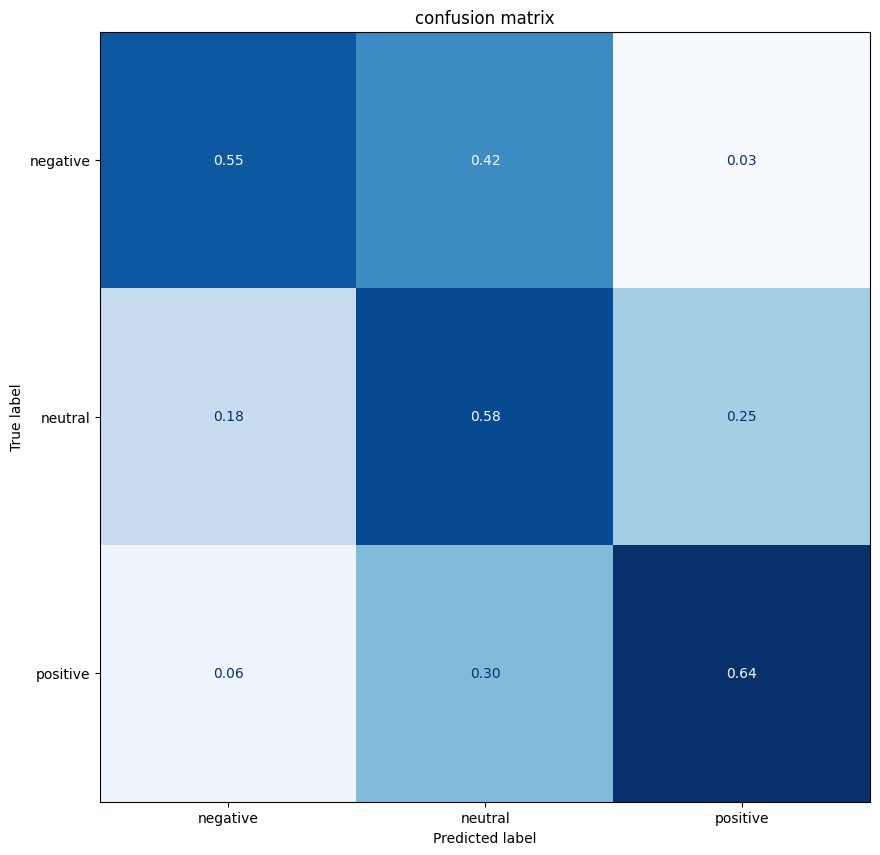

In [55]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation

In [56]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [57]:
preds_output.metrics

{'test_loss': 0.6434211730957031,
 'test_accuracy': 0.7302158273381295,
 'test_f1': 0.7340885825764073,
 'test_precision': 0.7489523928009917,
 'test_recall': 0.7265196625078209,
 'test_runtime': 19.6369,
 'test_samples_per_second': 353.926,
 'test_steps_per_second': 8.861}

In [58]:
y_preds = np.argmax(preds_output.predictions, axis=1)

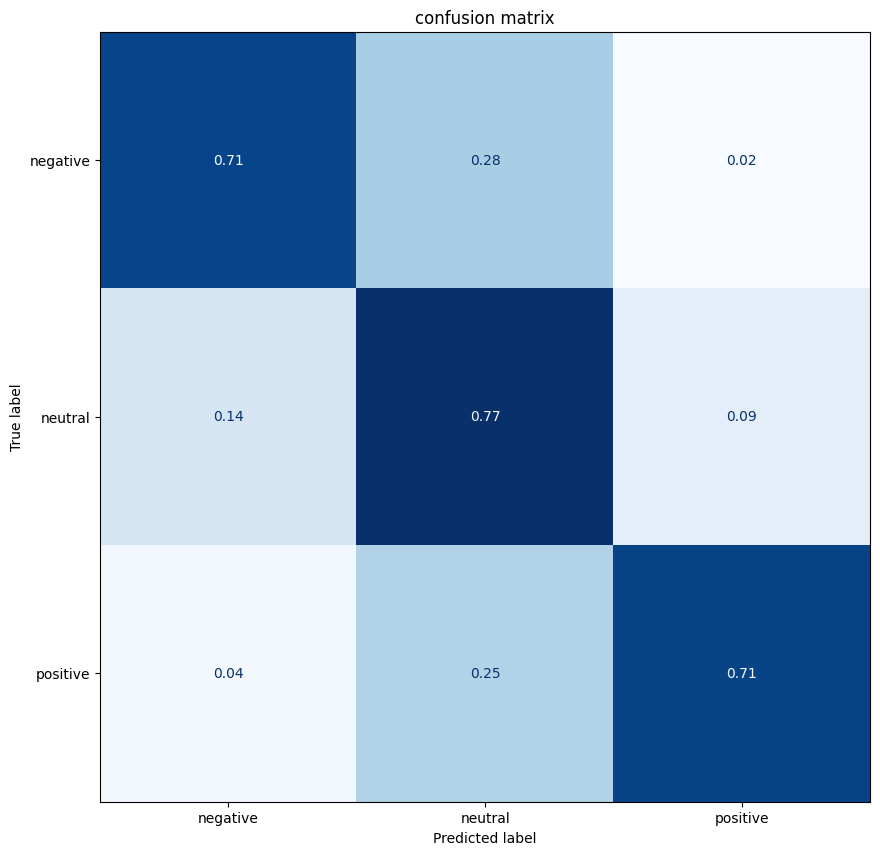

In [59]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [60]:
%%notify
import time
time.sleep(1)

<IPython.core.display.Javascript object>